In [26]:
import torch
from models.networks import get_model
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from data_utils.data_stats import *

import numpy as np
import matplotlib.pyplot as plt



/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')

model = nn.Sequential(
    nn.Flatten(1, -1),model
)

Weights already downloaded
Load_state output <All keys matched successfully>


In [41]:
# creating an input
#img = torch.zeros((3,224,224))
mean = 0.5
std = 0.03
input = mean + std*torch.randn((3,64,64)) # should be of size 3,64,64
input.unsqueeze_(0) # create a mini-batch as expected by the model
input.requires_grad_()

# Function that takes an array an normalizes its content to be within the range 0-1
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

# Function that takes in an input batch (with only 1 element) and displays it as an image
def show_im(batch):
    img = batch.reshape(3,64,64).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))


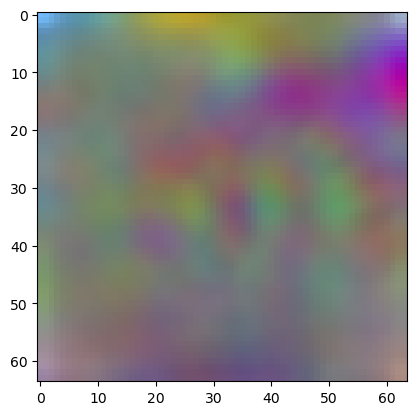

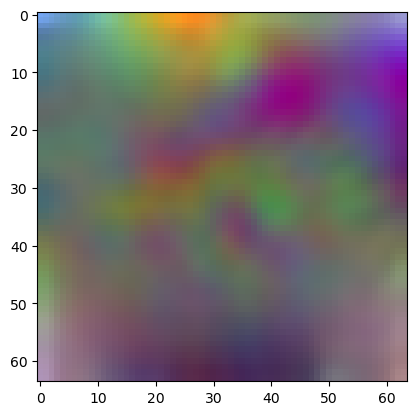

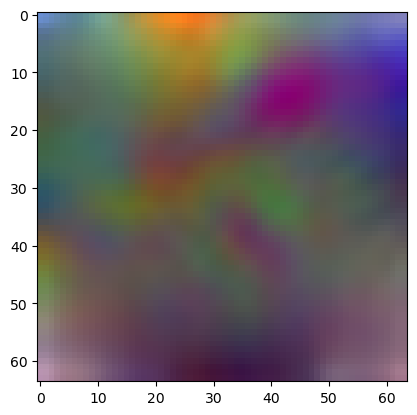

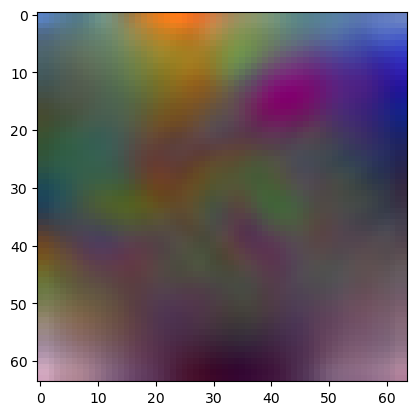

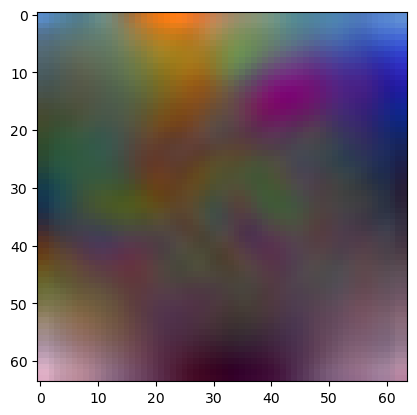

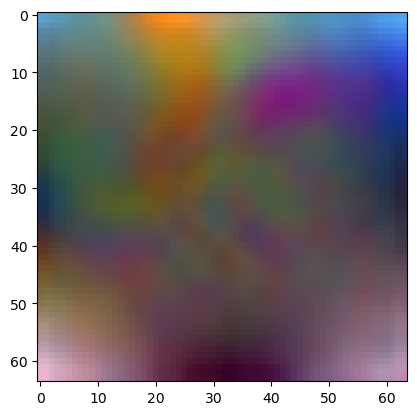

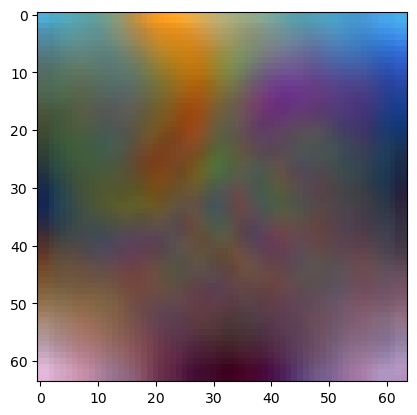

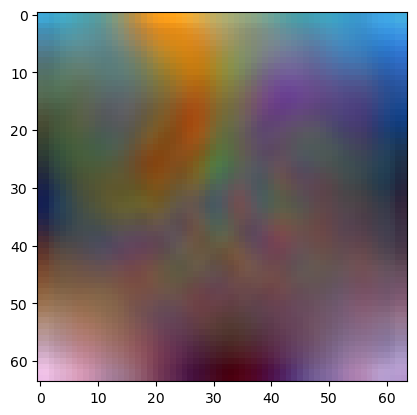

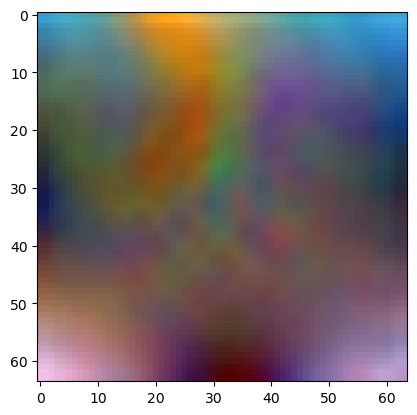

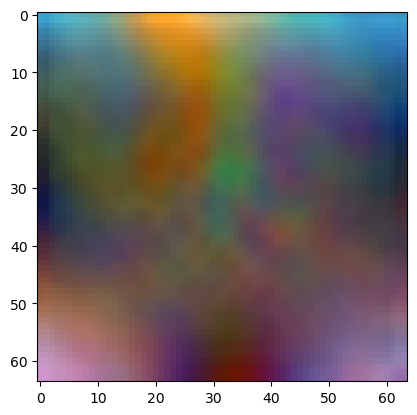

In [42]:
# Class I want to optimize
idx = 5 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks


epochs = 1000
start_step_size = 0.001
end_step_size = 0.001


start_sig = 1 #was 1 Having a decaying sigma seems to yield better results
end_sig = 0.5 
jitter = 7 # Jitter doesn't seem to help too much
theta_decay = 0.0001 # Theta decay seems to help (0.02 seems good)

num_im_save = 10

checkpoints = []

for epoch in range(epochs):
  
  model.zero_grad()
  if input.grad != None:
    input.grad.zero_()
  y_pred = model.forward(input)
  #print(y_pred[0,idx])
  y_pred[0,idx].backward()

  g = input.grad
  # ox, oy = np.random.randint(-jitter, jitter+1, 2)
  
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input += step_size/np.abs(g).mean() * g

    # input = input.roll( ox, -1) # apply jitter shift
    # input = input.roll( oy, -2)

    input = input.mul((1.0 - theta_decay)) # weight decay

    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input = blurrer(input)    

  input.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input)
    show_im(input)
    plt.show()



In [8]:
with torch.no_grad():
    output = model(input)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output)
print(output)
print(torch.argmax(probabilities))
print(torch.max(probabilities))

tensor([[ 71473.4062,  79895.2188,  89380.7500, -82816.6172,  76020.6562,
         662531.8750,  35023.9492,  51390.8086, 115956.8047,  97114.9453]])
tensor(5)
tensor(1.)


/var/folders/0f/d0nxyk0d5cq8n2nlbpm3wp3h0000gn/T/ipykernel_10345/1259139260.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(output)
